<a href="https://colab.research.google.com/github/avani1998/early_detection_of_plant_disease/blob/main/DeepLearningMajorProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing the required libraries

In [ ]:
!pip install deeplake tensorflow-addons
import deeplake
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_addons as tfa
import tensorflow_datasets as tfds

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.9/475.9 kB 12.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 36.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 89.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.7/72.7 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 92.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.7/132.7 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Loading the PlantVillage dataset using the TensorFlow-Datasets library:

In [ ]:
(ds_train, ds_val), ds_info = tfds.load(
    'plant_village',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/plant_village/1.0.2.incompleteOYMDMM/plant_village-train.tfrecord*...:   0…

Dataset plant_village downloaded and prepared to /root/tensorflow_datasets/plant_village/1.0.2. Subsequent calls will reuse this data.


Creating a custom function to preprocess the dataset:

In [ ]:
def preprocess_data(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    label = tf.one_hot(label, depth=ds_info.features['label'].num_classes)
    return image, label

Applying the preprocessing function to the training and validation sets:

In [ ]:
train_ds = ds_train.map(preprocess_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_ds = ds_val.map(preprocess_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)

Batching and prefetching the dataset for better performance

In [ ]:
batch_size = 32
train_ds = train_ds.batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_ds = val_ds.batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

we can load and preprocess the additional datasets and combine them with the PlantVillage dataset. However, we need to consider the following challenges:

The Rice Leaf Diseases dataset has 3 classes, and the Tomato Leaf Disease dataset has 10 classes. We need to re-index the labels to avoid conflicts when combining the datasets.

The images in the Rice Leaf Diseases and Tomato Leaf Disease datasets are of different sizes. We need to resize them to match the PlantVillage dataset's image size (256x256).

Let's try to do it in the following next steps.

Here's the plan to load and preprocess the additional datasets:

1) Download the datasets from Kaggle and upload them to your Google Colab environment.

2) Unzip the datasets.

3) Create functions to preprocess the datasets, including resizing the images and re-indexing the labels.

4) Load the datasets and apply the preprocessing functions.

5) Combine the datasets with the PlantVillage dataset.



Let's start with downloading and unzipping the datasets. You'll need to configure Kaggle API to download the datasets directly to your Google Colab environment. Follow these steps:

Visit your Kaggle account page and click on "Create New API Token" to download your kaggle.json file.

Upload the kaggle.json file to Google Colab:

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sasankkuppili","key":"ad71e953d53edd4e8bbc33535a6a16d6"}'}

Installing the Kaggle library and set the API credentials:

In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Download and unzip the Rice Leaf Diseases dataset:

In [ ]:
!kaggle datasets download -d vbookshelf/rice-leaf-diseases
!unzip -q rice-leaf-diseases.zip

100% 36.7M/36.7M [00:00<00:00, 125MB/s] 
100% 36.7M/36.7M [00:00<00:00, 105MB/s]


In [ ]:
!kaggle datasets download -d noulam/tomato
!unzip -q tomato.zip

 99% 737M/743M [00:06<00:00, 127MB/s]
100% 743M/743M [00:06<00:00, 127MB/s]


Importing additional necessary libraries:

In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing import image


Creating a function to load and preprocess the Rice Leaf Diseases dataset:

In [ ]:
def load_rice_leaf_diseases_dataset(image_size=(256, 256)):
    base_path = "rice_leaf_diseases"
    folders = os.listdir(base_path)
    images = []
    labels = []

    label_mapping = {
        "Bacterial leaf blight": 38,
        "Brown spot": 39,
        "Leaf smut": 40,
    }

    for folder in folders:
        folder_path = os.path.join(base_path, folder)
        for file in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file)
            img = image.load_img(file_path, target_size=image_size)
            img = image.img_to_array(img)
            images.append(img)
            labels.append(label_mapping[folder])

    images = np.array(images) / 255.0
    labels = np.array(labels)

    return images, labels

Creating a function to load and preprocess the Tomato Leaf Disease dataset:

In [ ]:
def load_tomato_leaf_disease_dataset(image_size=(256, 256)):
    base_path = "New Plant Diseases Dataset(Augmented)"
    train_path = os.path.join(base_path, "train")
    classes = sorted(os.listdir(train_path))
    images = []
    labels = []

    label_mapping = {cls: i + 41 for i, cls in enumerate(classes)}

    for cls in classes:
        cls_path = os.path.join(train_path, cls)
        for file in os.listdir(cls_path):
            file_path = os.path.join(cls_path, file)
            img = image.load_img(file_path, target_size=image_size)
            img = image.img_to_array(img)
            images.append(img)
            labels.append(label_mapping[cls])

    images = np.array(images) / 255.0
    labels = np.array(labels)

    return images, labels


Loading and preprocessing the Rice Leaf Diseases and Tomato Leaf Disease datasets:

In [ ]:
rice_images, rice_labels = load_rice_leaf_diseases_dataset()
tomato_images, tomato_labels = load_tomato_leaf_disease_dataset()

Splitting the additional datasets into training and validation sets (80/20 split):

In [ ]:
rice_train_images, rice_val_images, rice_train_labels, rice_val_labels = train_test_split(rice_images, rice_labels, test_size=0.2, random_state=42)
tomato_train_images, tomato_val_images, tomato_train_labels, tomato_val_labels = train_test_split(tomato_images, tomato_labels, test_size=0.2, random_state=42)

In [ ]:
rice_train_ds = tf.data.Dataset.from_tensor_slices((rice_train_images, rice_train_labels))
rice_val_ds = tf.data.Dataset.from_tensor_slices((rice_val_images, rice_val_labels))

tomato_train_ds = tf.data.Dataset.from_tensor_slices((tomato_train_images, tomato_train_labels))
tomato_val_ds = tf.data.Dataset.from_tensor_slices((tomato_val_images, tomato_val_labels))

In [ ]:
rice_train_ds = rice_train_ds.map(preprocess_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)
rice_val_ds = rice_val_ds.map(preprocess_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)

tomato_train_ds = tomato_train_ds.map(preprocess_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tomato_val_ds = tomato_val_ds.map(preprocess_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)


In [ ]:
rice_train_ds = rice_train_ds.batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
rice_val_ds = rice_val_ds.batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

tomato_train_ds = tomato_train_ds.batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
tomato_val_ds = tomato_val_ds.batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


In [ ]:
train_ds = train_ds.concatenate(rice_train_ds).concatenate(tomato_train_ds)
val_ds = val_ds.concatenate(rice_val_ds).concatenate(tomato_val_ds)

Visualizing and understanding the dataset is an important part of the project. Here are some steps to perform basic analysis and visualization of the dataset.

In [ ]:
class_names = ds_info.features['label'].names
print(f"Class names: {class_names}")

Class names: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry___healthy', 'Cherry___Powdery_mildew', 'Corn___Cercospora_leaf_spot Gray_leaf_spot', 'Corn___Common_rust', 'Corn___healthy', 'Corn___Northern_Leaf_Blight', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___healthy', 'Strawberry___Leaf_scorch', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___healthy', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_mosaic_virus

Plot a few sample images with their corresponding labels:

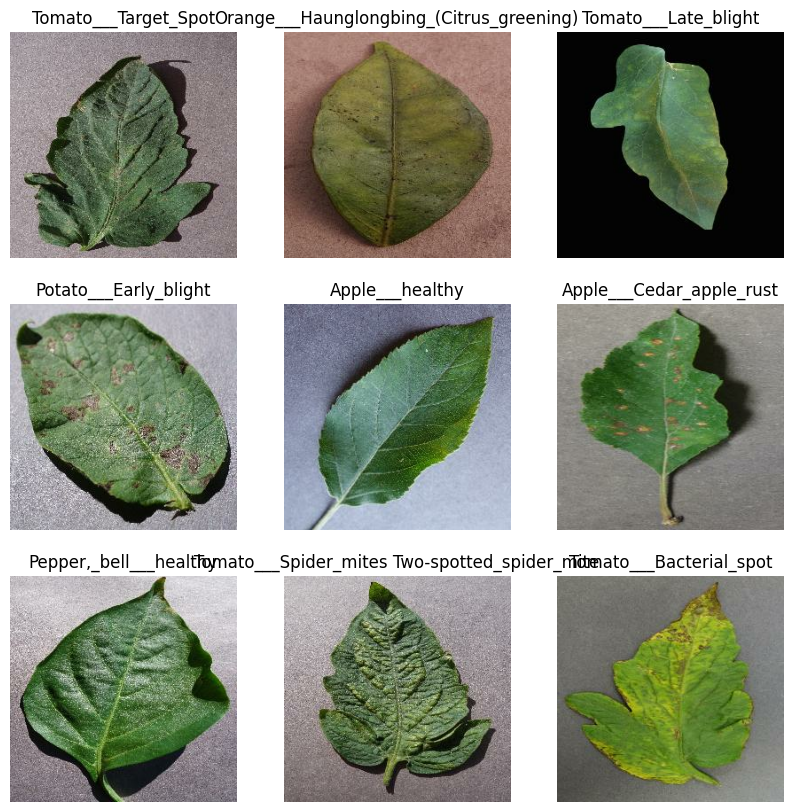

In [ ]:
def plot_original_samples(dataset, num_samples=9):
    plt.figure(figsize=(10, 10))
    
    # Get the first batch
    image_batch, label_batch = next(iter(dataset))
    
    for i in range(num_samples):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow((image_batch[i].numpy() * 255).astype("uint8"))  # Scale the pixel values back to the original range
        plt.title(class_names[np.argmax(label_batch[i].numpy())])
        plt.axis("off")
    plt.show()

plot_original_samples(train_ds)


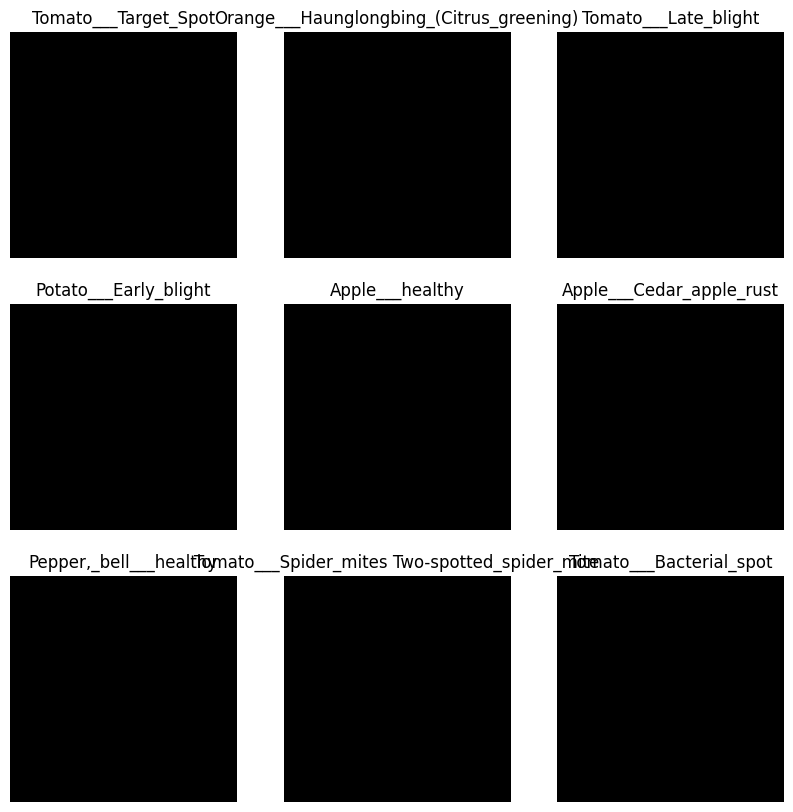

In [ ]:
def plot_samples(dataset, num_samples=9):
    plt.figure(figsize=(10, 10))
    
    # Get the first batch
    image_batch, label_batch = next(iter(dataset))
    
    for i in range(num_samples):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(label_batch[i].numpy())])
        plt.axis("off")
    plt.show()

plot_samples(train_ds)


Compute the total number of samples in the training and validation datasets:

In [ ]:
def count_samples(dataset):
    return sum([1 for _ in dataset])

train_samples = count_samples(train_ds.unbatch())
val_samples = count_samples(val_ds.unbatch())

print(f"Number of training samples: {train_samples}")
print(f"Number of validation samples: {val_samples}")


Number of training samples: 58214
Number of validation samples: 14554


Calculate the distribution of classes in the training dataset:

In [ ]:
from collections import Counter

def class_distribution(dataset):
    labels = [np.argmax(label.numpy()) for _, label in dataset.unbatch()]
    counter = Counter(labels)
    distribution = {class_names[i]: count for i, count in counter.items()}
    return distribution

train_distribution = class_distribution(train_ds)
print("Class distribution in the training dataset:")
for cls, count in train_distribution.items():
    print(f"{cls}: {count}")


Class distribution in the training dataset:
Tomato___Target_Spot: 1124
Orange___Haunglongbing_(Citrus_greening): 4399
Tomato___Late_blight: 1535
Potato___Early_blight: 792
Apple___healthy: 1306
Apple___Cedar_apple_rust: 221
Pepper,_bell___healthy: 1173
Tomato___Spider_mites Two-spotted_spider_mite: 1360
Tomato___Bacterial_spot: 1732
Squash___Powdery_mildew: 1466
Tomato___healthy: 1261
Cherry___Powdery_mildew: 851
Tomato___Tomato_mosaic_virus: 303
Tomato___Tomato_Yellow_Leaf_Curl_Virus: 4252
Peach___Bacterial_spot: 1838
Strawberry___Leaf_scorch: 923
Apple___Apple_scab: 15273
Soybean___healthy: 4043
Corn___healthy: 939
Blueberry___healthy: 1210
Apple___Black_rot: 467
Grape___Black_rot: 956
Grape___Leaf_blight_(Isariopsis_Leaf_Spot): 881
Pepper,_bell___Bacterial_spot: 800
Corn___Common_rust: 953
Tomato___Septoria_leaf_spot: 1409
Tomato___Early_blight: 807
Tomato___Leaf_Mold: 758
Grape___Esca_(Black_Measles): 1111
Corn___Northern_Leaf_Blight: 788
Potato___Late_blight: 801
Raspberry___healt

# -----------------------------------------------------------------------END--------------------------------------------------------------------------------------

We'll start with the PlantVillage dataset. Since we want to use online datasets without downloading and uploading them, we can utilize the tf.keras.utils.get_file() function. The PlantVillage dataset is available on the following link:

'https://data.mendeley.com/datasets/tywbtsjrjv/1/files/d5652a28-c1d8-4b76-97f3-72fb80f94efc/Plant_leaf_diseases_dataset_without_augmentation.zip'

We will download the dataset, extract it, and then split it into training and validation sets. Paste the following code into a new cell in your notebook and run it:

## This Step is throwing an error, Hence We are proceeding with an alternate method of using the PlantVillage dataset from google drive. 

In [ ]:
dataset_url = 'https://data.mendeley.com/datasets/tywbtsjrjv/1/files/d5652a28-c1d8-4b76-97f3-72fb80f94efc/Plant_leaf_diseases_dataset_without_augmentation.zip'
data_dir = tf.keras.utils.get_file('PlantVillage.zip', origin=dataset_url, extract=True, cache_dir='/content')
data_dir = os.path.join(os.path.dirname(data_dir), 'Plant_leaf_diseases_dataset_without_augmentation')

train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


The PlantVillage dataset is also available through the Activeloop platform. This can be a more efficient way to load the dataset directly into your project. To use the Activeloop version of the PlantVillage dataset, first, install the hub library:

In [ ]:
!pip install hub

The correct way to load the dataset is by using the deeplake library, as mentioned on the website.

Regarding your question, it depends on your project requirements and whether you would like to have additional augmented data for training.

Loading the dataset without augmentation means you will have the original dataset without any artificial modifications to the images. This is suitable if you want to train the model on the original dataset and evaluate its performance without the influence of augmented images.

Loading the dataset with augmentation means you will have the original dataset plus additional augmented images created by applying various transformations, such as rotation, flipping, and zooming. This can help improve your model's generalization and performance, as it provides more diverse training data.

For your use case, I would recommend starting with the dataset without augmentation. This allows you to establish a baseline performance for your models on the original dataset. Later, if you find that your model is overfitting or you want to improve its performance, you can consider using the dataset with augmentation.

To load the PlantVillage dataset without augmentation using the deeplake library, use the following code:

In [ ]:
!pip install deeplake

In [ ]:
import deeplake
ds = deeplake.load("hub://activeloop/plantvillage-without-augmentation")

-

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/plantvillage-without-augmentation



\

hub://activeloop/plantvillage-without-augmentation loaded successfully.



Preprocessing is an essential step in deep learning projects, as it helps transform raw data into a suitable format for training and evaluation. In the context of your project, preprocessing involves the following steps:

1) Rescaling pixel values: In image datasets, each pixel has a value between 0 and 255. It's common to rescale these values to a range of 0 to 1, as it helps the model converge faster and perform better during training.

2) Splitting the dataset: It's important to split the dataset into training and validation sets. The training set is used to train the model, while the validation set is used to evaluate the model's performance during training. This helps in monitoring overfitting and adjusting hyperparameters.

3) One-hot encoding of labels: Since this is a multi-class classification problem, it's necessary to convert the categorical labels into one-hot encoded vectors. This makes it easier for the model to understand the relationship between different labels and predict the correct class probabilities.

4)Creating data generators: Data generators help feed the preprocessed data to the model in batches during training and evaluation. This is especially useful when working with large datasets that cannot be loaded entirely into memory. Data generators also make it easier to apply data augmentation if needed.

In [ ]:
ds.visualize()

In [ ]:
labels_list = ds.labels.info['class_names']

In [ ]:
print(ds)

Dataset(path='hub://activeloop/plantvillage-without-augmentation', read_only=True, tensors=['images', 'labels'])


In [ ]:
images = ds['images']
labels = ds['labels']


In [ ]:
!pip install deeplake tensorflow-addons


In [ ]:
import tensorflow_addons as tfa

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
ds_dict = ds.__dict__

In [ ]:
print(ds_dict.keys())

dict_keys(['_client', 'ds_name', 'path', 'storage', '_read_only_error', '_read_only', 'base_storage', '_locked_out', 'is_iteration', 'is_first_load', '_is_filtered_view', 'index', 'group_index', '_token', 'org_id', 'public', 'verbose', 'version_state', 'link_creds', 'libdeeplake_dataset', '_info', '_ds_diff', '_view_id', '_view_base', '_view_use_parent_commit', '_update_hooks', '_commit_hooks', '_checkout_hooks', '_parent_dataset', '_pad_tensors', '_locking_enabled', '_temp_tensors', '_vc_info_updated', 'enabled_tensors', '_initial_autoflush', '_indexing_history'])


In [ ]:
train_ds, val_ds = train_test_split(ds, test_size=0.2, stratify=ds["label"].numpy(), random_state=42)

TensorDoesNotExistError: ignored